### Problem description

Here we seek to solve

\begin{align*}
\min_{\rho\in H^{1}(\Omega)}f(\rho)&:=\frac{1}{2}\int_{\Omega}\nabla\rho\cdot\nabla\rho\,\mathrm{d}V\\
\Omega&=\left(0,1\right)\subset\mathbb{R}
\end{align*}

such that

\begin{align*}
\int_{\Omega}\rho\,\mathrm{d}V&\leq \Omega_{f} \\
\rho(x=0)&=\rho_{0} \\
\rho(x=1)&=\rho_{1} \\
\rho(x)&\geq \rho_{\ell}(x)\quad x\in\overline{\Omega}
\end{align*}

We introduce a slack variable $y\in\mathbb{R}$, so that the equivalent reformulation is compatible with the structure of the developed filter line search software, that is we seek to solve

\begin{align*}
\min_{(\rho,y)\in H^{1}(\Omega)\times\mathbb{R}}f(\rho,y)&:=\frac{1}{2}\int_{\Omega}\nabla\rho\cdot\nabla\rho\,\mathrm{d}V\\
\Omega&=\left(0,1\right)\subset\mathbb{R}
\end{align*}

such that

\begin{align*}
\int_{\Omega}\rho\,\mathrm{d}V+y-\Omega_{f}&=0 \\
\rho(x=0)&=\rho_{0} \\
\rho(x=1)&=\rho_{1} \\
\rho(x)&\geq \rho_{\ell}(x)\quad x\in\overline{\Omega} \\
y &\geq 0
\end{align*}




In [1]:
import dolfin as dl
import numpy as np
import matplotlib.pyplot as plt
from filterLineSearch import interior_pt
from problems import example3
from helperfunctions import grad_check

In [2]:
nx = 20
mesh = dl.UnitIntervalMesh(nx)
Vh1 = dl.FunctionSpace(mesh, 'CG', 1)
test = dl.TestFunction(Vh1)
trial = dl.TrialFunction(Vh1)

Kform = dl.inner(dl.grad(test), dl.grad(trial))*dl.dx(mesh)
K     = dl.assemble(Kform).array()
Mform = test * trial * dl.dx(mesh)
M     = dl.assemble(Mform).array()

In [3]:
Omegaf = 0.1
rhol   = 0.0*np.ones(Vh1.dim())
rho0   = 0.05
rho1   = 0.05   

problem = example3(Vh1.dim(), K, M, rhol, Omegaf, rho0, rho1)

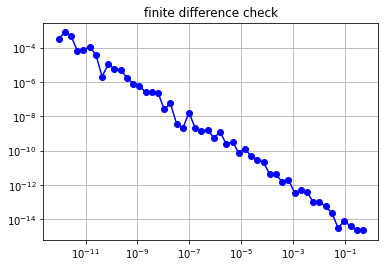

In [4]:
#---- gradient checks

x0    = 2. + np.abs(np.random.randn(problem.n))
F     = lambda x : problem.c(x)
gradF = lambda x : problem.Dxc(x)
xhat = np.random.randn(problem.n)
grad_check(F, gradF, x0, xhat)

In [5]:
solver  = interior_pt(problem, "direct")

x0      = 1. * np.ones(problem.n)
X0      = [x0, np.ones(problem.m), np.ones(problem.n2)]
solver.initialize(X0)
complementarity0 = np.linalg.norm(X0[2][:]*(x0[problem.n1:] - problem.rhol[:]), np.inf)
feasibility0     = problem.theta(x0)
optimality0      = np.linalg.norm(problem.DxL(X0), 2)

mu0 = 1.e0
tol = 1.e-8
max_it = 30
Xf, mu, E, Mus = solver.solve(tol, max_it, mu0)



-------------------------------------------------- it = 0
solved barrier problem (mu = 1.000e+00)
solved barrier problem (mu = 5.000e-01)
solved barrier problem (mu = 2.500e-01)
-------------------------------------------------- determining search direction 
NO INERTIA CORRECTION WAS REQUIRED
alpha = 5.808e-01, alphaz = 1.000e+00
in filter region?  False
A.5.4
theta(x) = 2.33e+00
angle between xhat and Dxphi = 35.4 (degrees)
descent direction?  False
theta(x) < theta_min?  False
step accepted A-5.4 CASE II
linesearch success?  True
accepted trial point for the subproblem
-------------------------------------------------- it = 1
solved barrier problem (mu = 1.250e-01)
-------------------------------------------------- determining search direction 
NO INERTIA CORRECTION WAS REQUIRED
alpha = 4.218e-01, alphaz = 1.000e+00
in filter region?  False
A.5.4
theta(x) = 9.76e-01
angle between xhat and Dxphi = 87.9 (degrees)
descent direction?  False
theta(x) < theta_min?  False
step accepted A-5.

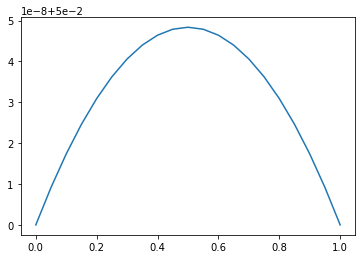

[0.05       0.05000001 0.05000002 0.05000002 0.05000003 0.05000004
 0.05000004 0.05000004 0.05000005 0.05000005 0.05000005 0.05000005
 0.05000005 0.05000004 0.05000004 0.05000004 0.05000003 0.05000002
 0.05000002 0.05000001 0.05       0.04999997]


In [6]:
rhosolution = dl.Function(Vh1)
rhosolution.vector().set_local(Xf[0][:-1])
dl.plot(rhosolution)
plt.show()
print(Xf[0])

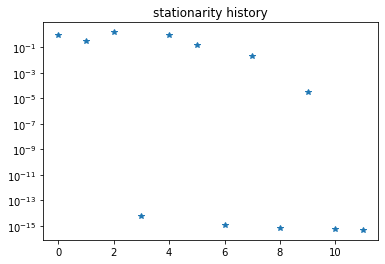

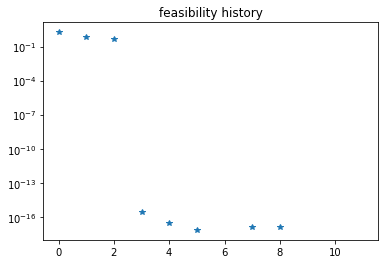

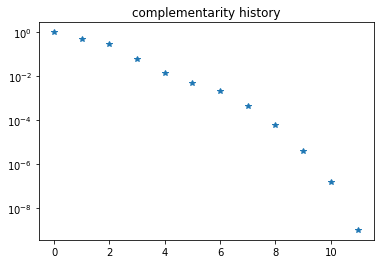

In [7]:
Es = [np.array([E[i][j] for i in range(len(E))]) for j in range(len(E[0]))]

titles = ["stationarity", "feasibility", "complementarity"]
for j in range(1,4):
    plt.plot(Es[j], "*")
    plt.title(titles[j-1] + " history")
    plt.yscale('log')
    plt.show()